In [1]:
# Text network analysis.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim

C:\Users\Jurgis\AppData\Local\conda\conda\envs\data_science\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Loading and preprocessing data.
tweets = pd.read_csv('tweets.csv')
tweets_text = [gensim.utils.simple_preprocess(text) for text in tweets['text']]

# Removing the stopwords.
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

tweets_final = []
for sent in tweets_text:
    sent_filtered = [w for w in sent if not w in stop_words]
    tweets_final.append(sent_filtered)

In [3]:
# Training Word2Vec model.
w2v = gensim.models.Word2Vec(tweets_final,
                             size=150,
                             window=7,
                             min_count=50,
                             workers=10)                         
w2v.train(tweets_final, total_examples=len(tweets_final), epochs=20)

(290882, 1176520)

In [6]:
from sklearn.manifold import TSNE

# Creating a vocabulary
labels = []
tokens = []
for word in w2v.wv.vocab:
    tokens.append(w2v[word])
    labels.append(word)
    

C:\Users\Jurgis\AppData\Local\conda\conda\envs\data_science\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [5]:
# Creating TSNE model.
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)
new_values = tsne_model.fit_transform(tokens)
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    

In [10]:
# Clustering for better visualization.
# Trying three clusters, that seem relevant to our data.
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, DBSCAN, KMeans

In [11]:
# Parameters are default for now. Will adjust if needed.
nclust = 8
sc = SpectralClustering(n_clusters=nclust) 
hc = AgglomerativeClustering(n_clusters=nclust)
dbscan = DBSCAN()
kmeans = KMeans(n_clusters=nclust)

In [ ]:
X = pd.DataFrame(toke)

In [8]:
# Fitting the models with t-SNE dimensionality reduced data. Predicting for visualizing
X = pd.DataFrame({'x': x,
                  'y': y})
sc_pred = sc.fit_predict(X)
hc_pred = hc.fit_predict(X)
dbscan_pred = dbscan.fit_predict(X)
kmeans_pred = kmeans.fit_predict(X)

In [9]:
# Placing everything into a single dataset.
cluster_data = pd.DataFrame({
    'x': x,
    'y': y,
    'Spectral clustering': sc_pred,
    'Hierarchical clustering (Ward)': hc_pred,
    'Density-based spatial clustering': dbscan_pred,
    'K-Means clustering': kmeans_pred
})

# Melting.
cluster_data = cluster_data.melt(value_vars=['Spectral clustering',
                           'Hierarchical clustering (Ward)',
                           'Density-based spatial clustering',
                           'K-Means clustering'],
                  id_vars=['x', 'y'],
                  value_name='Category',
                  var_name='Method')

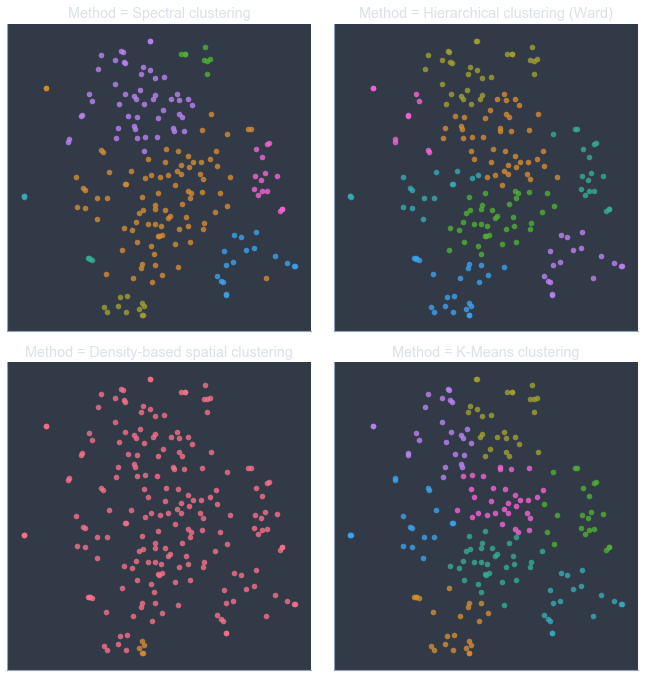

In [10]:
# Visualizing the clusters.
import seaborn as sns
sns.set_palette('Paired')

ax = sns.lmplot(x='x',
           y='y',
           data=cluster_data,
           fit_reg=False,
           hue='Category',
           col='Method',
           col_wrap=2,
           legend=False
           
      )

ax.set(xlabel='', ylabel='', yticks=[], xticks=[])
# Dbns looks pathetic. Hierarchical and K-Means look good, but they classify outliers in the same class,
# whereas Spectral Clustering assigns it to a different class (for example, youtube links).

In [11]:
# Adding a sentiment value for each word.
# VADER sentiment analysis.
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Getting the polarity scores of tweets
scores = []
for label in labels:
    scores.append(sid.polarity_scores(label))
    
# Converting to pandas dataframe and joining with the final dataframe.
scores = pd.DataFrame(scores)['compound'].tolist()

In [12]:
# Adjusting Spectral Clustering for a better fit.
sc = SpectralClustering(n_clusters=10, random_state=0) 
sc_pred = sc.fit_predict(X)
sc_data = pd.DataFrame({
    'x': x,
    'y': y,
    'category': sc_pred,
    'labels': labels,
    'sentiment': scores
})

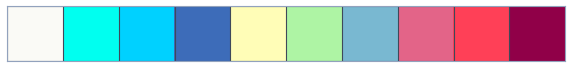

In [13]:
# Color palette used (still ugly in my oppinion - first 4 colors are hot).
colors = ['#fafaf6','#00fff0','#00d1ff','#3d6cb9','#fffdb7','#aef4a4','#79b8d1','#e36488', '#ff4057', '#900048']
sns.palplot(colors)

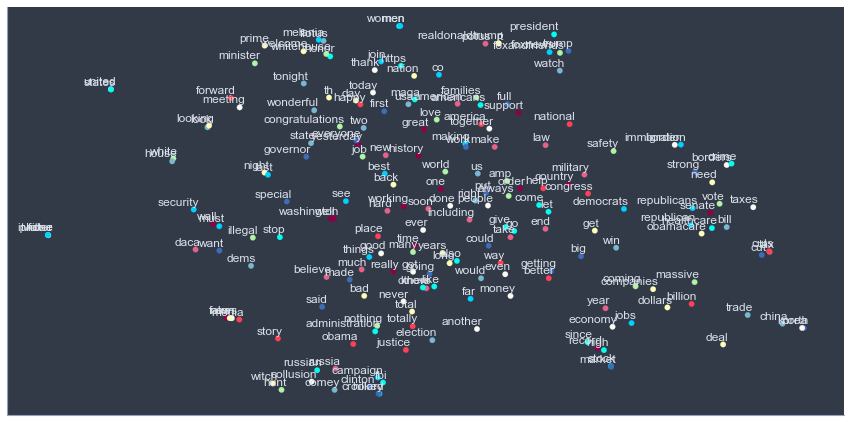

In [14]:
# Adjusting Spectral Clustering for a better fit.
sc = SpectralClustering(n_clusters=7, random_state=0) 
sc_pred = sc.fit_predict(X)
sc_data = pd.DataFrame({
    'x': x,
    'y': y,
    'category': sc_pred,
    'labels': labels,
    'sentiment': scores
})

# Plotting the final categorized graph.
fig, ax = plt.subplots(figsize=(15, 7.5))
i = 0
for cat in sc_data['category'].unique():
    plt.scatter(sc_data[sc_data['category'] == cat]['x'],
                sc_data[sc_data['category'] == cat]['y'],
                c=colors)
    i = i + 1

# Setting the labels of the subset.
for i in sc_data['x'].index:
    plt.annotate(sc_data['labels'][i],
                 xy=(sc_data['x'][i], sc_data['y'][i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                 fontsize=12)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(b=False)
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks([])
plt.figure(dpi=200)
plt.savefig('cbb.jpg')

In [16]:
'''
Plots a scatterplot with a single category highlighted.
 ** Vars: 
 * df, pandas.DataFrame object. Format should follow {
      'x': numeric x axis values,
      'y': numeric y axis values,
      'category': integer for categorical value,
      'labels': text labels for each data point
 }.
 * zoom_out, int: sets how far should the graph zoom out.
 * category, int: sets a category to be highlighted in the data.
 * category_color, str: sets the highlighted category's color. Should follow matplotlib's guidelines
for selecting a color.
'''
def discriminative_scatter(df,
                           zoom_out=1,
                           category=0,
                           category_color='#d9faff',
                           category_name='default'):
    # Splitting the data into 'has category' and 'else'.
    df_sub = df[df['category'] == category]
    df_else = df[df['category'] != category]

    # Base plots.
    fig, ax = plt.subplots(figsize=(15, 7.5))
    plt.scatter(df_sub['x'], df_sub['y'], color=category_color, s=40)
    plt.scatter(df_else['x'], df_else['y'], color='steelblue', alpha=0.6)

    # Getting and setting limits for zoom.
    ylim_lo, ylim_up = df_sub['y'].min() - df_sub['y'].std()*zoom_out, df_sub['y'].max() + df_sub['y'].std()*zoom_out
    plt.ylim(ylim_lo, ylim_up)

    xlim_lo, xlim_up = df_sub['x'].min() - df_sub['x'].std()*zoom_out, df_sub['x'].max() + df_sub['x'].std()*zoom_out
    plt.xlim(xlim_lo, xlim_up)

    # Setting the labels of the subset.
    for i in df_sub['x'].index:
        plt.annotate(df_sub['labels'][i],
                     xy=(df_sub['x'][i], df_sub['y'][i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontsize=12)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(b=False)
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks([])
    ax.legend([category_name, 'Else'])

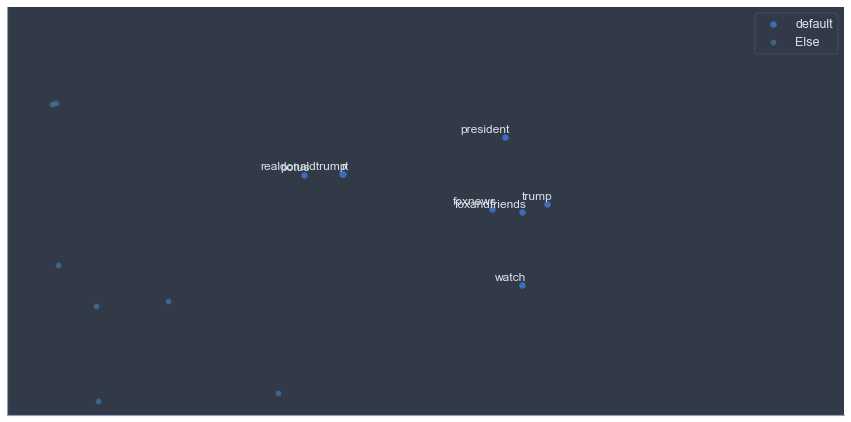

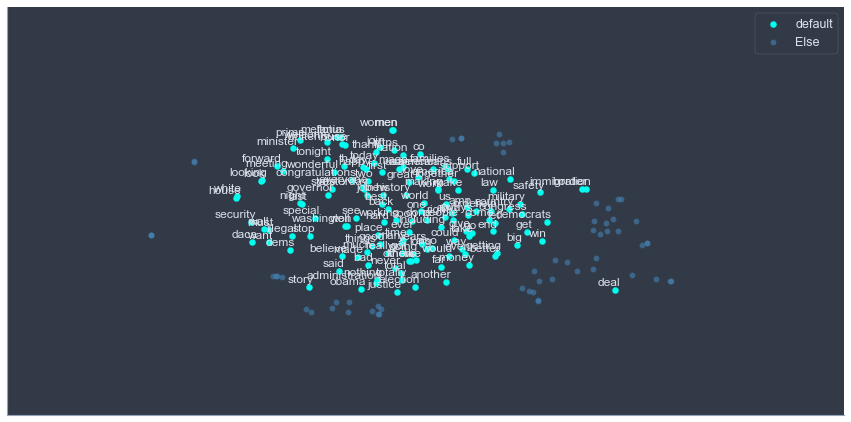

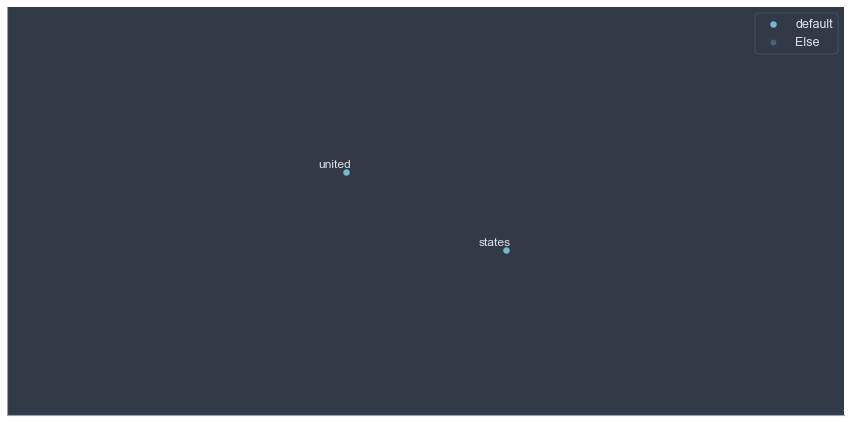

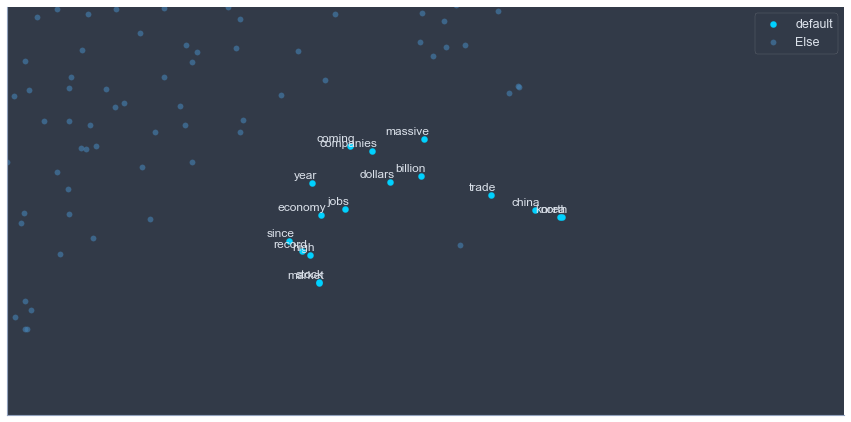

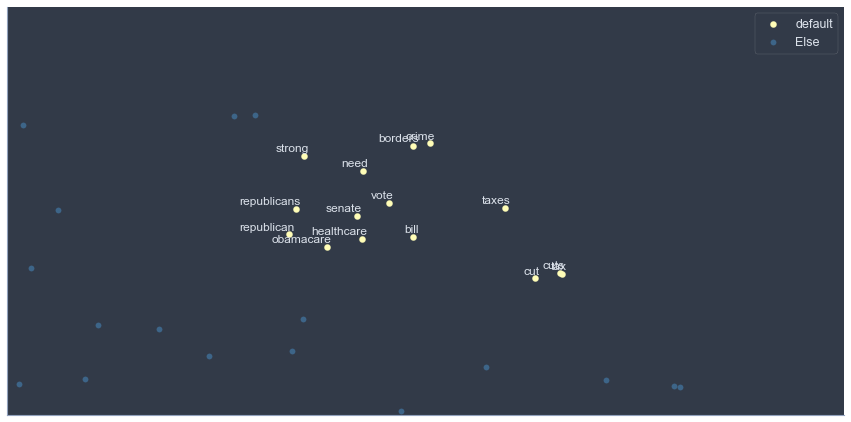

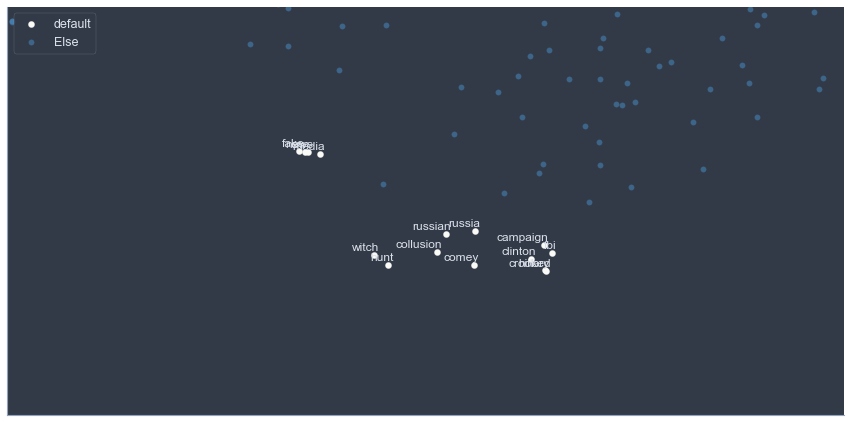

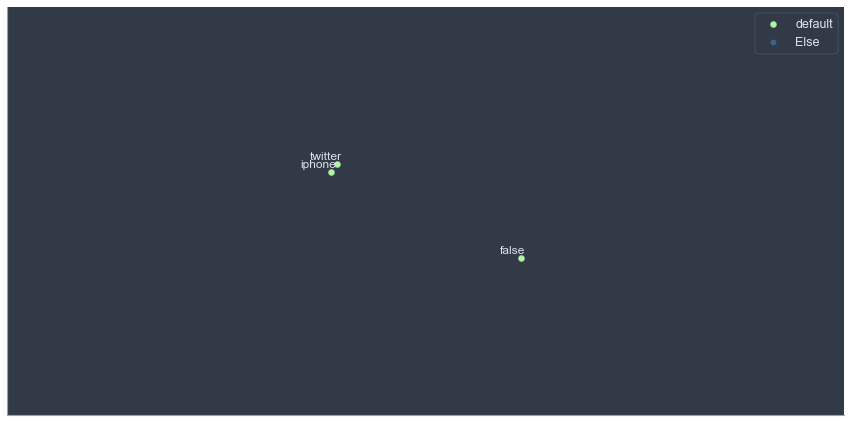

In [17]:
for cat in sc_data['category'].unique():
    discriminative_scatter(sc_data, category=cat, category_color=colors[cat], zoom_out=3)

In [18]:
# Visualizing.
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Generating plotly plot data.
plot_data = [go.Scatter(x=sc_data['x'],
                       y=sc_data['y'],
                       mode='markers+text',
                       marker=dict(
                           size=(sc_data['sentiment'] + 3)**2,
                           color=sc_data['sentiment'],
                           cmax=1,
                           cmin=-1,
                           colorscale='Viridis',
                           line=dict(
                               color='#65daf7',
                               width=1),
                           colorbar = dict(
                                title = '',
                                tickmode = 'array',
                                tickvals = [1, 0, -1],
                                ticktext = ['Positive', 'Neutral','Negative'],
                                ticks = 'outside',
                                thickness=12,
                                len=0.8,
                                outlinecolor='#65daf7',
                                tickfont=dict(
                                   family='calibri',
                                   size=12))
                       ),
                       text=labels,
                       textposition='top',
                       textfont=dict(
                           family='calibri',
                           size=14,
                           color='#4f6978')
                      )]

layout = go.Layout(
    xaxis=dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks='',
        showticklabels=False
    ),
    yaxis=dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks='',
        showticklabels=False
    )
)
fig = go.Figure(data=plot_data, layout=layout)
iplot(fig)